# Gaussian Processes Barycentres

In this notebook we'll give an implementation of
<strong data-cite="mallasto2017learning"></strong>. In this work, the existence of a
Wasserstein barycentre between a collection of Gaussian processes is proven. When
faced with trying to _average_ a set of probability distributions, the Wasserstein
barycentre is an attractive choice as it enables uncertainty amongst the individual
distributions to be incorporated into the averaged distribution. When compared to a
naive _mean of means_ and _mean of variances_ approach to computing the average
probability distributions, it can be seen that Wasserstein barycentres offer
significantly more favourable uncertainty estimation.


In [1]:
import typing as tp

import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.linalg as jsl
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox
import tensorflow_probability.substrates.jax.distributions as tfd
from jax.config import config

import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)
plt.style.use('./gpjax.mplstyle')
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Background

### Wasserstein distance

The 2-Wasserstein distance metric between two probability measures $\mu$ and $\nu$
quantifies the minimal cost required to transport the unit mass from $\mu$ to $\nu$,
or vice-versa. Typically, computing this metric requires solving a linear program.
However, when $\mu$ and $\nu$ both belong to the family of multivariate Gaussian
distributions, the solution is analytically given by
$$W_2^2(\mu, \nu) = \lVert m_1- m_2 \rVert^2_2 + \operatorname{Tr}(S_1 + S_2 - 2(S_1^{1/2}S_2S_1^{1/2})^{1/2}),$$
where $\mu \sim \mathcal{N}(m_1, S_1)$ and $\nu\sim\mathcal{N}(m_2, S_2)$.

### Wasserstein barycentre

For a collection of $T$ measures
$\lbrace\mu_i\rbrace_{t=1}^T \in \mathcal{P}_2(\theta)$, the Wasserstein barycentre
$\bar{\mu}$ is the measure that minimises the average Wasserstein distance to all
other measures in the set. More formally, the Wasserstein barycentre is the Fréchet
mean on a Wasserstein space that we can write as
$$\bar{\mu} = \operatorname{argmin}_{\mu\in\mathcal{P}_2(\theta)}\sum_{t=1}^T \alpha_t W_2^2(\mu, \mu_t),$$
where $\alpha\in\bbR^T$ is a weight vector that sums to 1.

As with the Wasserstein distance, identifying the Wasserstein barycentre $\bar{\mu}$
is often an computationally demanding optimisation problem. However, when all the
measures admit a multivariate Gaussian density, the barycentre
$\bar{\mu} = \mathcal{N}(\bar{m}, \bar{S})$ has analytical solutions
$$\bar{m} = \sum_{t=1}^T \alpha_t m_t\,, \quad \bar{S}=\sum_{t=1}^T\alpha_t (\bar{S}^{1/2}S_t\bar{S}^{1/2})^{1/2}\,. \qquad (\star)$$
Identifying $\bar{S}$ is achieved through a fixed-point iterative update.

## Barycentre of Gaussian processes

It was shown in <strong data-cite="mallasto2017learning"></strong> that the
barycentre $\bar{f}$ of a collection of Gaussian processes
$\lbrace f_i\rbrace_{i=1}^T$ such that $f_i \sim \mathcal{GP}(m_i, K_i)$ can be
found using the same solutions as in $(\star)$. For a full theoretical understanding,
we recommend reading the original paper. However, the central argument to this result
is that one can first show that the barycentre GP
$\bar{f}\sim\mathcal{GP}(\bar{m}, \bar{S})$ is non-degenerate for any finite set of
GPs $\lbrace f_t\rbrace_{t=1}^T$ i.e., $T<\infty$. With this established, one can
show that for a $n$-dimensional finite Gaussian distribution $f_{i,n}$, the
Wasserstein metric between any two Gaussian distributions $f_{i, n}, f_{j, n}$
converges to the Wasserstein metric between GPs as $n\to\infty$.

In this notebook, we will demonstrate how this can be achieved in GPJax.

## Dataset

We'll simulate five datasets and develop a Gaussian process posterior before
identifying the Gaussian process barycentre at a set of test points. Each dataset
will be a sine function with a different vertical shift, periodicity, and quantity
of noise.

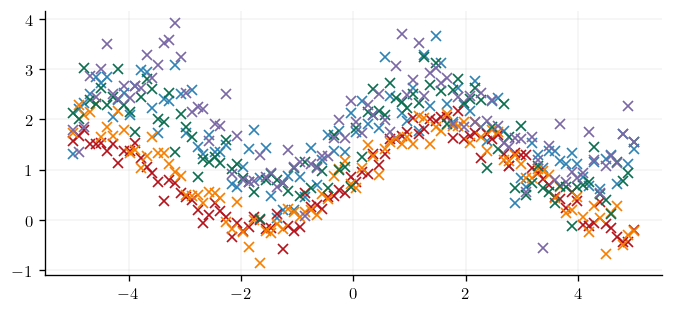

In [2]:
n = 100
n_test = 200
n_datasets = 5

x = jnp.linspace(-5.0, 5.0, n).reshape(-1, 1)
xtest = jnp.linspace(-5.5, 5.5, n_test).reshape(-1, 1)
f = lambda x, a, b: a + jnp.sin(b * x)

ys = []
for i in range(n_datasets):
    key, subkey = jr.split(key)
    vertical_shift = jr.uniform(subkey, minval=0.0, maxval=2.0)
    period = jr.uniform(subkey, minval=0.75, maxval=1.25)
    noise_amount = jr.uniform(subkey, minval=0.01, maxval=0.5)
    noise = jr.normal(subkey, shape=x.shape) * noise_amount
    ys.append(f(x, vertical_shift, period) + noise)

y = jnp.hstack(ys)

fig, ax = plt.subplots()
ax.plot(x, y, "x")
plt.show()

## Learning a posterior distribution

We'll now independently learn Gaussian process posterior distributions for each
dataset. We won't spend any time here discussing how GP hyperparameters are
optimised. For advice on achieving this, see the
[Regression notebook](https://gpjax.readthedocs.io/en/latest/nbs/regression.html)
for advice on optimisation and the
[Kernels notebook](https://gpjax.readthedocs.io/en/latest/nbs/kernels.html) for
advice on selecting an appropriate kernel.

In [3]:
def fit_gp(x: jax.Array, y: jax.Array) -> tfd.MultivariateNormalFullCovariance:
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    D = gpx.Dataset(X=x, y=y)

    likelihood = gpx.Gaussian(num_datapoints=n)
    posterior = gpx.Prior(mean_function=gpx.Constant(), kernel=gpx.RBF()) * likelihood

    opt_posterior, _ = gpx.fit(
        model=posterior,
        objective=jax.jit(gpx.ConjugateMLL(negative=True)),
        train_data=D,
        optim=ox.adamw(learning_rate=0.01),
        num_iters=500,
    )
    latent_dist = opt_posterior.predict(xtest, train_data=D)
    return opt_posterior.likelihood(latent_dist)


posterior_preds = [fit_gp(x, i) for i in ys]

/Users/tompinder/Development/JaxGPDevs/GPJax/gpjax/fit.py:190: UserWarning: Objective is jit-compiled. Please ensure that the objective is of type gpjax.Objective.
  warn("Objective is jit-compiled. Please ensure that the objective is of type gpjax.Objective.")


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

## Computing the barycentre

In GPJax, the predictive distribution of a GP is given by a
[TensorFlow Probability](https://www.tensorflow.org/probability/api_docs/python/tfp/substrates/jax)
distribution, making it
straightforward to extract the mean vector and covariance matrix of each GP for
learning a barycentre. We implement the fixed point scheme given in (3) in the
following cell by utilising Jax's `vmap` operator to speed up large matrix operations
using broadcasting in `tensordot`.

In [4]:
def sqrtm(A: jax.Array):
    return jnp.real(jsl.sqrtm(A))


def wasserstein_barycentres(
    distributions: tp.List[tfd.MultivariateNormalFullCovariance], weights: jax.Array
):
    covariances = [d.covariance() for d in distributions]
    cov_stack = jnp.stack(covariances)
    stack_sqrt = jax.vmap(sqrtm)(cov_stack)

    def step(covariance_candidate: jax.Array, idx: None):
        inner_term = jax.vmap(sqrtm)(
            jnp.matmul(jnp.matmul(stack_sqrt, covariance_candidate), stack_sqrt)
        )
        fixed_point = jnp.tensordot(weights, inner_term, axes=1)
        return fixed_point, fixed_point

    return step

With a function defined for learning a barycentre, we'll now compute it using the
`lax.scan` operator that drastically speeds up for loops in Jax (see the
[Jax documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html)).
The iterative update will be executed 100 times, with convergence measured by the
difference between the previous and current iteration that we can confirm by
inspecting the `sequence` array in the following cell.

In [5]:
weights = jnp.ones((n_datasets,)) / n_datasets

means = jnp.stack([d.mean() for d in posterior_preds])
barycentre_mean = jnp.tensordot(weights, means, axes=1)

step_fn = jax.jit(wasserstein_barycentres(posterior_preds, weights))
initial_covariance = jnp.eye(n_test)

barycentre_covariance, sequence = jax.lax.scan(
    step_fn, initial_covariance, jnp.arange(100)
)
L = jnp.linalg.cholesky(barycentre_covariance)

barycentre_process = tfd.MultivariateNormalTriL(barycentre_mean, L)

## Plotting the result

With a barycentre learned, we can visualise the result. We can see that the result
looks reasonable as it follows the sinusoidal curve of all the inferred GPs, and the
uncertainty bands are sensible.

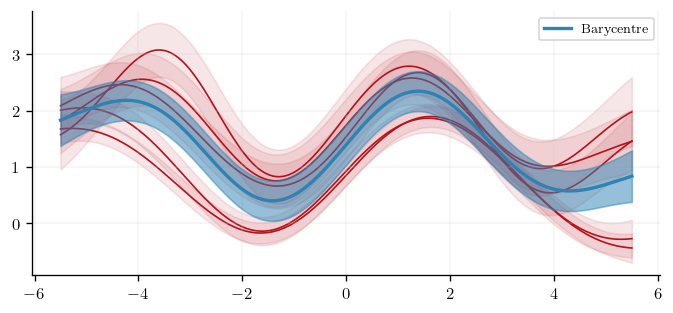

In [6]:
def plot(
    dist: tfd.MultivariateNormalTriL,
    ax,
    color: str,
    label: str = None,
    ci_alpha: float = 0.2,
    linewidth: float = 1.0,
    zorder: int = 0,
):
    mu = dist.mean()
    sigma = dist.stddev()
    ax.plot(xtest, mu, linewidth=linewidth, color=color, label=label, zorder=zorder)
    ax.fill_between(
        xtest.squeeze(), mu - sigma, mu + sigma, alpha=ci_alpha, color=color, zorder=zorder
    )


fig, ax = plt.subplots()
[plot(d, ax, color=cols[1], ci_alpha=0.1) for d in posterior_preds]
plot(
    barycentre_process,
    ax,
    color=cols[0],
    label="Barycentre",
    ci_alpha=0.5,
    linewidth=2,
    zorder=1
)
ax.legend()

## Displacement interpolation

In the above example, we assigned uniform weights to each of the posteriors within
the barycentre. In practice, we may have prior knowledge of which posterior is most
likely to be the correct one. Regardless of the weights chosen, the barycentre
remains a Gaussian process. We can interpolate between a pair of posterior
distributions $\mu_1$ and $\mu_2$ to visualise the corresponding barycentre
$\bar{\mu}$.

![](figs/barycentre_gp.gif)

## System configuration

In [7]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Thomas Pinder (edited by Daniel Dodd)'

Author: Thomas Pinder (edited by Daniel Dodd)

Last updated: Fri Apr 21 2023

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.11.0

matplotlib            : 3.7.1
jax                   : 0.4.8
tensorflow_probability: 0.19.0
optax                 : 0.1.4
gpjax                 : 0.5.9.post47.dev0+4f510ee

Watermark: 2.3.1

